In [1]:
import numpy as np
import scipy.io
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
from scipy.stats import spearmanr
import networkx as nx


In [2]:
# Move out of the notebook folder to access datasets
working_dir = os.getcwd()
data_dir = working_dir + "/results/Gender/"

titleee = "Gender"

# Validation classification analysis

In [3]:
def load_mat_file(file_path, key):
    # Load the MATLAB file
    data = scipy.io.loadmat(file_path)
    # Assuming the labels or predictions are stored under the key 'labels'
    return data[key].squeeze()

def compute_metrics(true_labels, predicted_labels):
    # Calculate different metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    return accuracy, precision, recall, f1

def plot_confusion_matrix(true_labels, predicted_labels, title = ''):
    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # Normalize the confusion matrix by the number of instances in each class (rows)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create the plot
    fig, ax = plt.subplots()
    cax = ax.matshow(cm_normalized, cmap=plt.cm.Blues)
    
    # Add title and labels
    plt.title(title + 'Confusion Matrix', fontsize = 15)
    fig.colorbar(cax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks(np.arange(len(np.unique(true_labels))))
    ax.set_yticks(np.arange(len(np.unique(true_labels))))
    ax.set_xticklabels(np.unique(true_labels))
    ax.set_yticklabels(np.unique(true_labels))
    ax.xaxis.set_ticks_position('bottom')

    # Add numbers to each cell
    for (i, j), val in np.ndenumerate(cm_normalized):
        ax.text(j, i, f"{val:.2%}", ha='center', va='center', color='black')

    # Display the plot
    plt.show()

In [4]:
# Load results
true_labels = load_mat_file(data_dir + "Confusion_Val_Lab.mat", "labels")
predictions = load_mat_file(data_dir + "Confusion_Val.mat", "predictions")

Accuracy: 0.6619718309859155
Precision: 0.6595886752136753
Recall: 0.6590505767524402
F1 Score: 0.6592605758976182


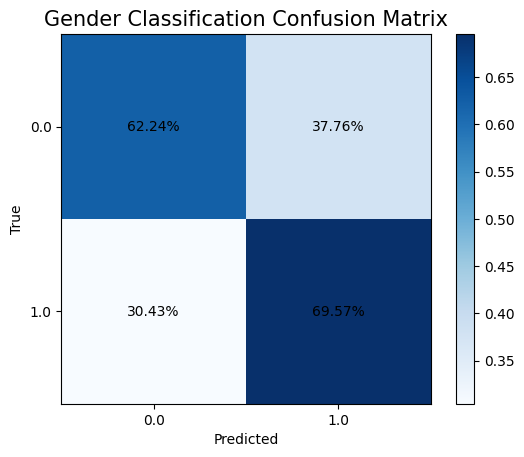

In [5]:
# Compute classification metrics
accuracy, precision, recall, f1 = compute_metrics(true_labels, predictions)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Plot confusion matrix
plot_confusion_matrix(true_labels, predictions, title = titleee + ' Classification ')

# Knock Up and Down

In [6]:
# Load the inference results
kup = load_mat_file(data_dir + "Knockup.mat", "Knockup")
kdown = load_mat_file(data_dir + "Knockdown.mat", "Knockdown")

# Adjust dimension
kup = kup.T
kdown = kdown.T

# Load list of genes used
selected_genes_df = pd.read_csv(data_dir + 'selected_genes.csv')


In [7]:
def find_sample_changes(predictions, modifications):
    # Changes matrix: 1 if changed, 0 if not
    changes = modifications != predictions[:, None]
    # Sum changes for each gene
    return np.sum(changes, axis=0)


changes_kup = find_sample_changes(predictions, kup)
changes_kdown = find_sample_changes(predictions, kdown)

gene_effects_df = pd.DataFrame({
    'Affected_samples_kup': changes_kup,
    'Affected_samples_kdown': changes_kdown
}, index=selected_genes_df['Gene Name'])

# Sum kup and kdown changes to get total effect per gene
gene_effects_df['Total_affected_samples'] = gene_effects_df['Affected_samples_kup'] + gene_effects_df['Affected_samples_kdown']

# Sort the DataFrame by Total_affected_samples
gene_effects_df = gene_effects_df.sort_values(by='Total_affected_samples', ascending=False).reset_index()

# Remove genes with no effect
gene_effects_df = gene_effects_df[gene_effects_df['Total_affected_samples'] != 0]


print(gene_effects_df)

    Gene Name  Affected_samples_kup  Affected_samples_kdown  \
0     SLC11A1                    82                      82   
1        BMP3                    77                      77   
2       MMP14                    72                      72   
3      TSPAN1                    72                      72   
4       CCL22                    61                      61   
..        ...                   ...                     ...   
246   CEACAM5                     1                       1   
247       PI3                     1                       1   
248    CDKN2B                     1                       1   
249      KLK8                     1                       1   
250      KLK7                     1                       1   

     Total_affected_samples  
0                       164  
1                       154  
2                       144  
3                       144  
4                       122  
..                      ...  
246                       2  
247

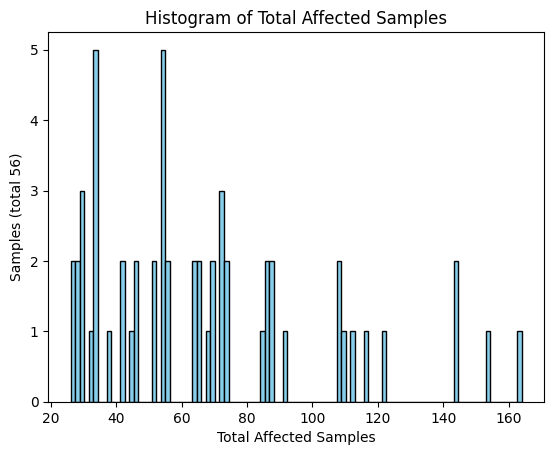

In [8]:
# Make a subset of genes with more consensus
modules = gene_effects_df[gene_effects_df['Total_affected_samples'] > 25]


# Create a histogram of Total_affected_samples
plt.hist(modules['Total_affected_samples'], bins=100, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Total Affected Samples')
plt.ylabel(f'Samples (total {modules.shape[0]})')
plt.title('Histogram of Total Affected Samples')

# Show the plot
plt.show()

In [9]:
working_dir = os.getcwd()
working_dir = working_dir.strip('GCNN_paper_adaptation')
data_dir = working_dir + 'Thesis/data/PROTECTED_DATA/BGI_Expression_Data/'


## Load the datasets
# Transcriptomics Data 
transcriptomics_TumorOnly_dir = data_dir + 'CRC.SW.mRNA.symbol.TPM_TumorOnly.csv'
transcriptomics_dataset = pd.read_csv(transcriptomics_TumorOnly_dir, index_col=0)

# Classification Tags
labels_classification_dir = data_dir + 'TumourSite_for_TumorSamples_Classification.csv'
labels = pd.read_csv(labels_classification_dir, index_col=0)

In [10]:
modules = modules[['Gene Name', 'Total_affected_samples']]
transcriptomics_dataset_transposed = transcriptomics_dataset.transpose()
transcriptomics_dataset_transposed.reset_index(inplace=True)
transcriptomics_dataset_transposed.rename(columns={'index': 'Gene Name'}, inplace=True)
expression_profile = pd.merge(modules, transcriptomics_dataset_transposed, on='Gene Name', how='inner')


In [ ]:
## Save the modules to csv for comparative analysis.
working_dir = os.getcwd()
results_dir = working_dir + '/results/ComparativeAnalysis/'

# Check if the directory exists, and if not, create it
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    print(f"Creating directory to save results and figures...")


expression_profile.to_csv(results_dir + 'GenderModulesExP_GCNN.csv')

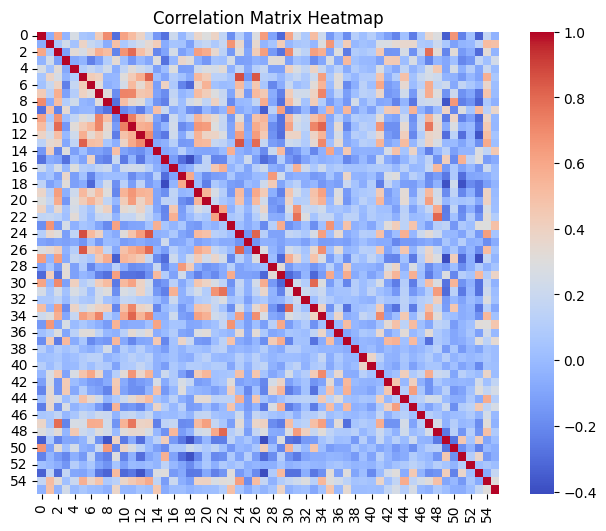

In [11]:
expression_data = expression_profile.drop(columns=['Total_affected_samples'])
expression_data.set_index('Gene Name', inplace=True)
expression_data_np = expression_data.values
correlation_matrix = np.corrcoef(expression_data_np, rowvar=True)

# plot
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [17]:
############
######33
######
#
#
#
#
wgcna_modules_dir = 'C:/Users/bxz19/Documents/Bioinfo UU/Year 2/Semester 2/Thesis/Work/Thesis/results/ComparativeAnalysis/TumorModulesExP_WGCNA.csv'
wgcna_modules = pd.read_csv(wgcna_modules_dir, index_col=0)


wgcna_modules_gender = wgcna_modules[wgcna_modules['Module'] == 58]
expression_data = wgcna_modules_gender.drop(columns=['Module'])
expression_data.set_index('Gene Name', inplace=True)
expression_data


In [21]:

## Eigengene

# Perform PCA on the expression data of the current module
pca = PCA(n_components=1)
pca.fit(expression_data)

# The first principal component is the eigengene
eigengene = pca.components_[0]

eigengene.shape

(1063,)

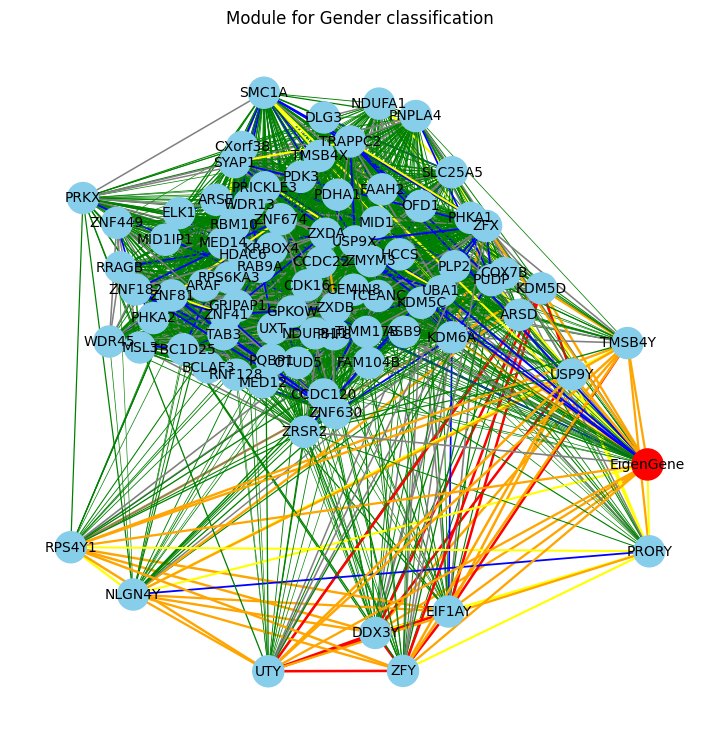

In [22]:
# Color mapping for different intervals of correlation strengths
interval_colors = {
    '0.9 - 1.0': 'red',
    '0.8 - 0.9': 'orange',
    '0.7 - 0.8': 'yellow',
    '0.6 - 0.7': 'blue',
    
    '0.0 - 0.5': 'green',
    }

# Function to determine color based on weight
def get_edge_color(weight, interval_colors):
    for interval, color in interval_colors.items():
        lower, upper = map(float, interval.split(' - '))
        if lower <= abs(weight) <= upper:
            return color
    return 'grey'

plt.figure(figsize=(7, 7))

# Build full expression profile
new_row = pd.DataFrame([eigengene], columns=expression_data.columns, index=['EigenGene'])
module_profile = pd.concat([expression_data, new_row])

# Convert to numpy and calculate Spearman correlation -> Membership function in a way
module_profile_matrix = module_profile.to_numpy()
corr, _ = spearmanr(module_profile_matrix, axis=1)
corr_matrix = pd.DataFrame(corr, index=module_profile.index, columns=module_profile.index)

# Network creation and node addition
G = nx.Graph()
for gene in module_profile.index:
    G.add_node(gene)

# Edge addition based on correlation
for gene1 in module_profile.index:
    for gene2 in module_profile.index:
        if gene1 != gene2:
            weight = corr_matrix.loc[gene1, gene2]
            if abs(weight) >= 0.2:
                color = get_edge_color(weight, interval_colors)
                G.add_edge(gene1, gene2, weight=weight, color=color)

# Plotting the network in a subplot
pos = nx.spring_layout(G, k=0.5, iterations=20)
edges = G.edges(data=True)
nx.draw(G, pos, with_labels=True, node_color=['red' if name=='EigenGene' else 'skyblue' for name in G.nodes], 
        node_size=500, 
        edge_color=[data['color'] for _, _, data in edges], linewidths=1, font_size=10,
        width=[(data['weight'])*2 for _, _, data in edges])

plt.title(f'Module for {titleee} classification')
plt.axis('off')


"""
# Add a legend for the whole figure
legend_labels = {label: plt.Line2D([0], [0], color=color, lw=4) for label, color in interval_colors.items()}
plt.figlegend(legend_labels.values(), legend_labels.keys(), loc='upper right')
plt.tight_layout()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
"""
plt.show()

In [13]:
## Correlation wih the trait

CT_for_TumorSamples_dir = data_dir + 'ClinicalTraits_for_TumorSamples.csv'
CT_for_TumorSamples = pd.read_csv(CT_for_TumorSamples_dir, index_col=0)
Trait_for_TumorSamples = CT_for_TumorSamples[titleee]

Trait_for_TumorSamples_numeric = Trait_for_TumorSamples.map({'Female': 0, 'Male': 1})

spearman_corr, p_value = spearmanr(Trait_for_TumorSamples_numeric, eigengene)

print(f"Spearman's rank correlation coefficient: {spearman_corr}")
print(f"P-value: {p_value}")

Spearman's rank correlation coefficient: -0.12265620028159305
P-value: 6.085089754338807e-05
